In [61]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [4]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [5]:
from lib.generators.OLP import OLP


generator = OLP(
    network_name='Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain', 
    seed=seed
)

feature_names = generator.feature_names

Loading file...
File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [6]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [8]:
link_prediction_train.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,299,676,0,0.000000,0.000250,0.000000,0.000541,0.0500,0.000000,0.000000,0.000000,1.002995e-15,8.162086e-16,-1.053825e-16
1,490,959,0,0.000000,0.000375,0.000000,0.000136,0.0075,0.000000,0.000000,0.000000,-3.005019e-17,9.823208e-16,4.499608e-17
2,647,760,0,0.000000,0.000125,0.000000,0.000206,0.0150,0.000000,0.000000,0.000000,1.077697e-16,1.025354e-15,-1.088061e-16
3,329,970,0,0.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,5.724032e-19,9.874755e-16,0.000000e+00
4,371,388,0,0.090909,0.000000,0.005556,0.001862,0.1125,0.037037,0.306928,0.038462,3.256266e-16,9.090909e-02,5.555556e-02


## Step 2
### Link prediction model

In [19]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,predicted_edge
0,299,676,0,0.000000,0.000250,0.000000,0.000541,0.0500,0.000000,0.000000,0.000000,1.002995e-15,8.162086e-16,-1.053825e-16,0.323173,0
1,490,959,0,0.000000,0.000375,0.000000,0.000136,0.0075,0.000000,0.000000,0.000000,-3.005019e-17,9.823208e-16,4.499608e-17,0.162052,0
2,647,760,0,0.000000,0.000125,0.000000,0.000206,0.0150,0.000000,0.000000,0.000000,1.077697e-16,1.025354e-15,-1.088061e-16,0.282849,0
3,329,970,0,0.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,5.724032e-19,9.874755e-16,0.000000e+00,0.168950,0
4,371,388,0,0.090909,0.000000,0.005556,0.001862,0.1125,0.037037,0.306928,0.038462,3.256266e-16,9.090909e-02,5.555556e-02,0.256074,0


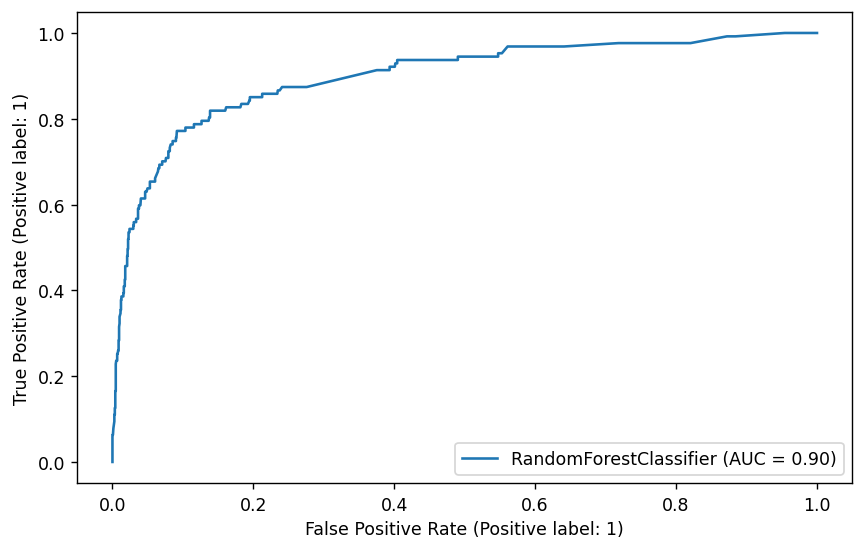

In [20]:
# ROC-AUC for the link prediction model
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model, link_prediction_test[feature_names], link_prediction_test['goal'])  

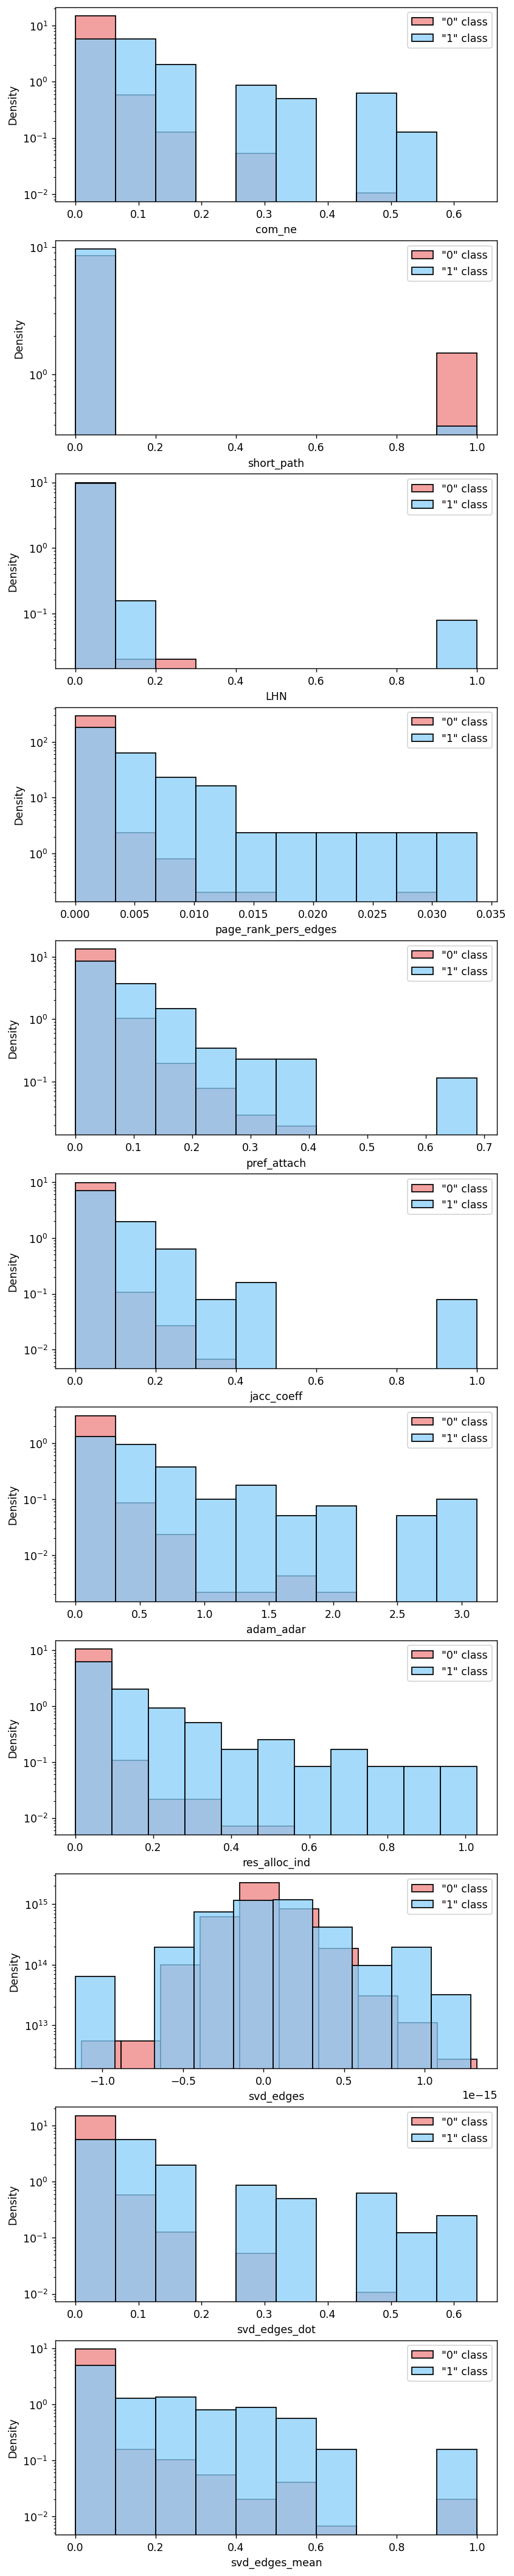

In [45]:
# distribution of features of exesting and non-existing edges

mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))
colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    width = (link_prediction_test[feature].max()-link_prediction_test[feature].min())/10
    for j in [0, 1]:
        data = link_prediction_test[link_prediction_test['goal'] == j]

        sn.histplot(data, x=feature, ax=axs[i], binwidth=width, color=colors[j], stat='density', label=f'"{j}" class')
        axs[i].set(xlabel=feature, ylabel='Density')
        axs[i].set_yscale("log")
        axs[i].legend()


## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [46]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,predicted_edge,abs_error
0,299,676,0,0.000000,0.000250,0.000000,0.000541,0.0500,0.000000,0.000000,0.000000,1.002995e-15,8.162086e-16,-1.053825e-16,0.323173,0,0.323173
1,490,959,0,0.000000,0.000375,0.000000,0.000136,0.0075,0.000000,0.000000,0.000000,-3.005019e-17,9.823208e-16,4.499608e-17,0.162052,0,0.162052
2,647,760,0,0.000000,0.000125,0.000000,0.000206,0.0150,0.000000,0.000000,0.000000,1.077697e-16,1.025354e-15,-1.088061e-16,0.282849,0,0.282849
3,329,970,0,0.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,5.724032e-19,9.874755e-16,0.000000e+00,0.168950,0,0.168950
4,371,388,0,0.090909,0.000000,0.005556,0.001862,0.1125,0.037037,0.306928,0.038462,3.256266e-16,9.090909e-02,5.555556e-02,0.256074,0,0.256074


In [47]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.45274811291130035

In [48]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,predicted_edge,abs_error,quality_label
0,299,676,0,0.000000,0.000250,0.000000,0.000541,0.0500,0.000000,0.000000,0.000000,1.002995e-15,8.162086e-16,-1.053825e-16,0.323173,0,0.323173,1
1,490,959,0,0.000000,0.000375,0.000000,0.000136,0.0075,0.000000,0.000000,0.000000,-3.005019e-17,9.823208e-16,4.499608e-17,0.162052,0,0.162052,1
2,647,760,0,0.000000,0.000125,0.000000,0.000206,0.0150,0.000000,0.000000,0.000000,1.077697e-16,1.025354e-15,-1.088061e-16,0.282849,0,0.282849,1
3,329,970,0,0.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,5.724032e-19,9.874755e-16,0.000000e+00,0.168950,0,0.168950,1
4,371,388,0,0.090909,0.000000,0.005556,0.001862,0.1125,0.037037,0.306928,0.038462,3.256266e-16,9.090909e-02,5.555556e-02,0.256074,0,0.256074,1


In [49]:
model_2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

RandomForestClassifier(max_depth=3, random_state=962)

In [53]:
# testing the classifier

pred = model_2.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])[:,1]
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [54]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.18171962389783497

In [55]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,545,556,0,0.0,0.000375,0.0,0.000074,0.005000,0.0,0.0,0.0,-1.426929e-16,9.889866e-16,1.069531e-17,0.165309,1,0.165309,1
1,114,853,0,0.0,0.000250,0.0,0.000074,0.011250,0.0,0.0,0.0,-3.580713e-16,9.337611e-16,-7.878423e-17,0.167976,1,0.167976,1
2,1078,1103,0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,-3.929009e-34,9.874709e-16,0.000000e+00,0.256074,1,0.256074,0
3,830,865,0,0.0,0.000250,0.0,0.000183,0.005000,0.0,0.0,0.0,1.460149e-16,1.038652e-15,2.431247e-16,0.168950,1,0.168950,1
4,49,720,0,0.0,0.000125,0.0,0.000377,0.053125,0.0,0.0,0.0,-3.507936e-16,1.102611e-15,9.911742e-17,0.335476,1,0.335476,0


In [63]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
0                     808
1                     808
dtype: int64

In [64]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1374
0                           242
dtype: int64

In [57]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    model_2.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1616.000000
1,Accuracy,0.566832
2,Precision,0.631221
3,Recall,0.566832
4,F1 score,0.506263


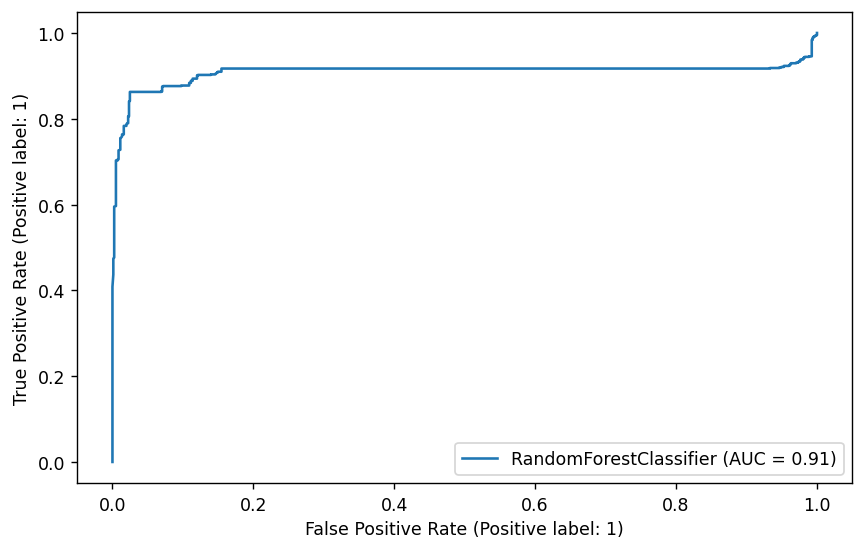

In [60]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])  

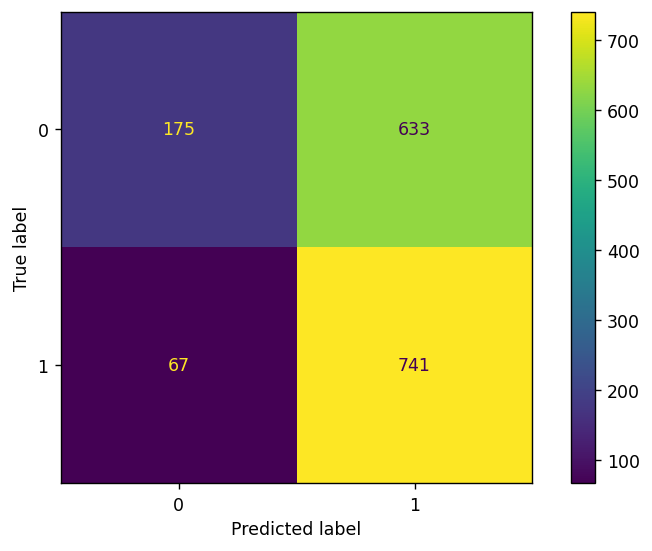

In [62]:
metrics.plot_confusion_matrix(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])